# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
TOPIC = "distance"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
ANNOTATOR = "erikt@xs4all.nl"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")

In [4]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if annotator == ANNOTATOR and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(tweets.loc[tweetId][TEXT]))}

In [5]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    if not fasttextData[tweetId][TEXT] in seenTexts:
        print(fasttextData[tweetId][LABEL],fasttextData[tweetId][TEXT],file=outFile)
        seenTexts[fasttextData[tweetId][TEXT]] = True
outFile.close()

In [6]:
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.3 ; 1000 tweets take: 190 minutes


## Fasttext run and evaluation

In [8]:
import fasttext
import random
from IPython.display import clear_output

In [9]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [10]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [21]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

2080

In [12]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [13]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [14]:
def evaluate(predictionCounts,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    if printResults: print("cases: {0}; precision: {1}; recall: {2}".format(caseTotal,precision,recall))
    return(precision)

## Grid search

In [15]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = " ".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts)

10 10 0.05 cases: 2079; precision: 0.595; recall: 0.595
10 10 0.1 cases: 2079; precision: 0.606; recall: 0.606
10 10 0.2 cases: 2079; precision: 0.646; recall: 0.646
10 20 0.05 cases: 2079; precision: 0.608; recall: 0.608
10 20 0.1 cases: 2079; precision: 0.649; recall: 0.649
10 20 0.2 cases: 2079; precision: 0.655; recall: 0.655
10 50 0.05 cases: 2079; precision: 0.656; recall: 0.656
10 50 0.1 cases: 2079; precision: 0.646; recall: 0.646
10 50 0.2 cases: 2079; precision: 0.648; recall: 0.648
10 100 0.05 cases: 2079; precision: 0.647; recall: 0.647
10 100 0.1 cases: 2079; precision: 0.646; recall: 0.646
10 100 0.2 cases: 2079; precision: 0.647; recall: 0.647
10 200 0.05 cases: 2079; precision: 0.644; recall: 0.644
10 200 0.1 cases: 2079; precision: 0.647; recall: 0.647
10 200 0.2 cases: 2079; precision: 0.645; recall: 0.645
10 300 0.05 cases: 2079; precision: 0.646; recall: 0.646
10 300 0.1 cases: 2079; precision: 0.647; recall: 0.647
10 300 0.2 cases: 2079; precision: 0.644; recall: 0

In [16]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k],reverse=True)][0:10]

[(0.658, '100 20 0.2'),
 (0.657, '200 20 0.2'),
 (0.656, '10 50 0.05'),
 (0.656, '50 20 0.2'),
 (0.655, '10 20 0.2'),
 (0.655, '100 50 0.05'),
 (0.655, '200 50 0.05'),
 (0.654, '300 20 0.2'),
 (0.654, '300 100 0.05'),
 (0.653, '20 20 0.2')]

## Run with best parameters

In [22]:
BESTDIM = 100
BESTEPOCH = 20
BESTLR = 0.2

predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [23]:
evaluate(predictionCounts)

cases: 2080; precision: 0.657; recall: 0.657


0.657

In [24]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__REJECTS': 314,
 '__label__SUPPORTS': 1238,
 '__label__IRRELEVANT': 528}

In [25]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.595


In [26]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__IRRELEVANT': 466,
 '__label__REJECTS': 228,
 '__label__SUPPORTS': 1386}

In [27]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 296


In [28]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__REJECTS': 0.274, '__label__SUPPORTS': 0.12, '__label__IRRELEVANT': 0.117}


In [29]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,227,58,243
__label__REJECTS,90,110,114
__label__SUPPORTS,149,60,1029


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [30]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__REJECTS': 1.3771929824561404,
 '__label__SUPPORTS': 0.8932178932178932,
 '__label__IRRELEVANT': 1.1330472103004292}

The multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [31]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

2080.0 2080


## Relation data size - accuracy

In [32]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [33]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCounts,predictionLabels = runFasttext(selection,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False)
        expResultsTrainingSize.append(evaluate(predictionCounts,printResults=False))
    expResultsAll[len(selection)] = 100*round(np.average(expResultsTrainingSize),3)
    print("{0:4} {1:0.1f}%".format(len(selection),expResultsAll[len(selection)]))
    if len(selection) >= len(fasttextData): break

 100 59.6%
 200 57.7%
 500 61.0%
1000 65.3%
2000 66.9%
2080 67.1%


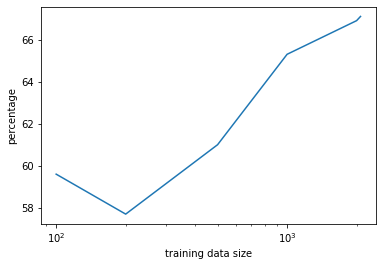

In [34]:
plt.figure(figsize=(6,4))
plt.plot(list(expResultsAll.keys()),list(expResultsAll.values()))
plt.xscale("log")
plt.ylabel("percentage")
plt.xlabel("training data size")
plt.show()

## Classifying unlabeled tweets

In [35]:
import fasttext
import matplotlib
import os
import pandas as pd
import re

In [36]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
SUPPORT = ""
TEXT = "text"
USER = "user"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [37]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| "+makeGrepCommandFromQuery(query)+" >> "+tmpFileName)
            try: df = pd.read_csv(tmpFileName)
            except: continue
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT],flags=re.IGNORECASE):
                    testData.append(df.iloc[i][USER]+" "+df.iloc[i][TEXT])
            os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query):
    testData = readData(datePattern,query)
    model = fasttext.train_supervised(FILEFASTTEXT,dim=DIM,epoch=EPOCH,lr=LR)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    return(labelPercentages)

In [38]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
MAXDAYSPERMONTH = 31

results = {}
for month in "202002 202003 202004 202005 202006 202007".split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY)
            if not REJECTS in labels: labels[REJECTS] = 0
            if not SUPPORTS in labels: labels[SUPPORTS] = 0
            if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
            if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                results[date] = labels
            print(date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT])
        except:
            print(date,"error")

20200201 0 100.0 232.6
20200202 4.3 95.7 278.3
20200203 3.1 96.9 127.7
20200204 4.8 95.2 212.9
20200205 1.9 98.1 139.6
20200206 25.5 74.5 168.1
20200207 6.0 94.0 140.3
20200208 1.8 98.2 183.6
20200209 5.0 95.0 167.5
20200210 3.6 96.4 89.2
20200211 3.4 96.6 450.8
20200212 5.7 94.3 148.6
20200213 8.5 91.5 198.6
20200214 0 100.0 172.3
20200215 2.4 97.6 295.1
20200216 1.9 98.1 192.3
20200217 1.5 98.5 149.3
20200218 5.4 94.6 121.6
20200219 2.7 97.3 144.6
20200220 2.0 98.0 731.4
20200221 8.5 91.5 348.9
20200222 17.4 82.6 234.8
20200223 4.8 95.2 156.6
20200224 1.0 99.0 157.0
20200225 22.6 77.4 109.7
20200226 2.6 97.4 236.8
20200227 2.2 97.8 114.8
20200228 6.1 93.9 94.8
20200229 10.1 89.9 166.7
20200230 error
20200231 error
20200301 10.0 90.0 85.8
20200302 3.6 96.4 77.5
20200303 8.2 91.8 72.2
20200304 0 100.0 157.1
20200305 37.9 62.1 110.5
20200306 44.7 55.3 73.9
20200307 27.1 72.9 73.6
20200308 17.5 82.5 40.5
20200309 2.9 97.1 43.2
20200310 1.0 99.0 54.7
20200311 1.7 98.3 47.0
20200312 2.0 98

## Visualization over time

In [39]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

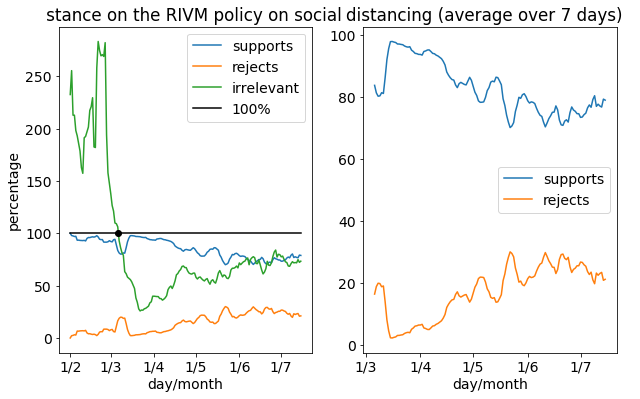

In [48]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7
STARTDATE = "20200306"
ENDDATE = "20201231"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(10,6))
x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

ax1 = plt.subplot(121)
plt.plot_date(x,ySupports,fmt="-",label="supports")
plt.plot_date(x,yRejects,fmt="-",label="rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="irrelevant")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("   stance on the RIVM policy on "+"social")

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(122)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="rejects")
plt.legend()
plt.xlabel("day/month")
plt.title("distancing (average over "+str(DAYSCOMBINED)+" days)  ")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 20200401 20200501 20200601 20200701".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.show()

In [41]:
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        print(list(results.keys())[i])

20200306
